# Estimate domains of translated protein product of isoforms

This notebook requires that the `hmmscan` compute job in [0.2.11] be complete.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import gffutils
import pybedtools
import re
import numpy as np

v19db_filename = '/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db'
v19db = gffutils.FeatureDB(v19db_filename)

folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'

In [3]:
splicing_feature_data = pd.read_csv('{}/splicing_feature_data.csv'.format(folder), index_col=0)
print splicing_feature_data.shape
splicing_feature_data.head()

(58842, 41)


,gencode_id,ensembl_id,gene_name,exon1_length,exon2_length,exon3_length,intron1_length,intron2_length,exon2_divisible_by_3,intron12_length_summed,...,isoform1_isoelectric_point,isoform2_isoelectric_point,isoform1_instability_index,isoform2_instability_index,isoform1_translation,isoform2_translation,isoform1_aromaticity,isoform2_aromaticity,isoform1_molecular_weight,isoform2_molecular_weight
event_id,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,492,681,148,True,829,...,NaN,4.26861572265625,NaN,102.2393258426966,NaN,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...,NaN,0.056179775280898875,NaN,9467.055499999997
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,487,681,148,True,829,...,4.05267333984375,4.26861572265625,88.44705882352942,102.2393258426966,HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFT...,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...,0.058823529411764705,0.056179775280898875,7294.6994,9467.055499999997
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,70,681,148,True,829,...,3.65948486328125,4.26861572265625,93.59464285714286,102.2393258426966,HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFT...,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...,0.07142857142857142,0.056179775280898875,6052.4400000000005,9467.055499999997
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,ENSG00000107521.14,ENSG00000107521,HPS1,152,161,100,2648,460,False,3108,...,NaN,4.97674560546875,NaN,59.58056910569105,NaN,LRPPDLAQRVQLWEHFQSLLWTYSRLREQEQCFAVEALERLIHPQL...,NaN,0.07317073170731708,NaN,14073.84609999998
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,ENSG00000107521.14,ENSG00000107521,HPS1,138,143,152,220,1180,False,1400,...,NaN,5.16119384765625,NaN,38.79076923076922,NaN,LPALEDQLSTLLAPVIISSMTMLEKLSDTYTCFSTENGNFLYVLHL...,NaN,0.11538461538461539,NaN,15151.241699999982


In [4]:
isoform_translations = splicing_feature_data[['isoform1_translation', 'isoform2_translation']]
isoform_translations.head()

,isoform1_translation,isoform2_translation
event_id,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFT...,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFT...,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,LRPPDLAQRVQLWEHFQSLLWTYSRLREQEQCFAVEALERLIHPQL...
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,LPALEDQLSTLLAPVIISSMTMLEKLSDTYTCFSTENGNFLYVLHL...


In [5]:
exons_to_junctions = pd.read_csv('{}/exons_to_junctions_se.csv'.format(folder), index_col=[0, 1, 2], squeeze=True, header=None)
exons_to_junctions = exons_to_junctions.reset_index()
exons_to_junctions = exons_to_junctions.rename(columns={0: 'exon1', 1: 'exon2', 2: 'exon3', 3:'junctions'})
exons_to_junctions.head()

,exon1,exon2,exon3,junctions
0,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100188908-100189399:-,"('chr10:100189647-100190327:-', 'chr10:1001894..."
1,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100188913-100189399:-,"('chr10:100189647-100190327:-', 'chr10:1001894..."
2,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100189330-100189399:-,"('chr10:100189647-100190327:-', 'chr10:1001894..."
3,exon:chr10:100193697-100193848:-,exon:chr10:100190888-100191048:-,exon:chr10:100190328-100190427:-,"('chr10:100191049-100193696:-', 'chr10:1001904..."
4,exon:chr10:100195392-100195529:-,exon:chr10:100195029-100195171:-,exon:chr10:100193697-100193848:-,"('chr10:100195172-100195391:-', 'chr10:1001938..."


In [6]:
exons_to_junctions['junctions'] = exons_to_junctions['junctions'].map(eval)
exons_to_junctions.head()

,exon1,exon2,exon3,junctions
0,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100188908-100189399:-,"(chr10:100189647-100190327:-, chr10:100189400-..."
1,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100188913-100189399:-,"(chr10:100189647-100190327:-, chr10:100189400-..."
2,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100189330-100189399:-,"(chr10:100189647-100190327:-, chr10:100189400-..."
3,exon:chr10:100193697-100193848:-,exon:chr10:100190888-100191048:-,exon:chr10:100190328-100190427:-,"(chr10:100191049-100193696:-, chr10:100190428-..."
4,exon:chr10:100195392-100195529:-,exon:chr10:100195029-100195171:-,exon:chr10:100193697-100193848:-,"(chr10:100195172-100195391:-, chr10:100193849-..."


In [7]:
prefix = 'skipped_exon_isoform_translations'
translated_fasta = '{}/{}.fa'.format(folder, prefix)

### Read HMMScan output

In [8]:
pd.options.display.max_columns = 30

In [9]:
from poshsplice.hmmscan import read_hmmscan

hmmscan_out = '{}/{}_hmmscan_pfamA.txt'.format(folder, prefix)
! ls -lha $hmmscan_out
hmmscan = read_hmmscan(hmmscan_out)
print hmmscan.shape
hmmscan.head()

-rw-r--r-- 1 obotvinnik yeo-group 106M Sep 25 18:39 /projects/ps-yeolab/obotvinnik/singlecell_pnms/skipped_exon_isoform_translations_hmmscan_pfamA.txt
(291331, 23)


,target_name,target_accession,target_length,query_name,query_accession,query_length,sequence_e_value,sequence_score,sequence_bias,domain_number,domain_total,domain_conditional_e_value,domain_independent_e_value,domain_score,domain_bias,target_start,target_stop,query_start,query_stop,query_domain_envelope_start,query_domain_envelope_stop,mean_posterior_probability,target_description
0,Aminotran_1_2,PF00155.16,363,exon:chr10:101165513-101165617:-@exon:chr10:10...,-,140,1.600000e-37,129.3,0.0,1,1,1.200000e-41,1.700000e-37,129.2,0.0,142,270,2,138,1,140,0.96,Aminotransferase class I and II
1,GDA1_CD39,PF01150.12,436,exon:chr10:101421203-101421385:+@exon:chr10:10...,-,179,1.800000e-27,95.9,0.0,1,1,2.800000e-31,2.100000e-27,95.7,0.0,4,104,75,179,72,179,0.90,GDA1/CD39 (nucleoside phosphatase) family
2,OppC_N,PF12911.2,56,exon:chr10:101421203-101421385:+@exon:chr10:10...,-,179,8.500000e-02,12.2,0.2,1,1,2.200000e-05,1.600000e-01,11.3,0.2,12,37,21,46,17,56,0.92,N-terminal TM domain of oligopeptide transport...
3,COX15-CtaA,PF02628.10,302,exon:chr10:101480744-101480825:-@exon:chr10:10...,-,117,8.100000e-23,80.7,0.2,1,1,6.300000e-27,9.300000e-23,80.5,0.2,165,270,7,117,2,117,0.85,Cytochrome oxidase assembly protein
4,CutC,PF03932.9,202,exon:chr10:101507014-101507147:+@exon:chr10:10...,-,60,1.800000e-18,66.5,0.0,1,1,1.300000e-22,1.900000e-18,66.4,0.0,123,180,1,58,1,60,0.98,CutC family


Split query name (event name + cds + isoform information) into separate columns

In [10]:
hmmscan.query_name.head().values

array([ 'exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-|CDS:chr10:101165513-101165617:-:0@CDS:chr10:101163481-101163631:-:0@CDS:chr10:101163226-101163391:-:2|isoform2',
       'exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+|CDS:chr10:101421203-101421385:+:1@CDS:chr10:101439018-101439223:+:1@CDS:chr10:101439482-101439632:+:2|isoform2',
       'exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+|CDS:chr10:101421203-101421385:+:1@CDS:chr10:101439018-101439223:+:1@CDS:chr10:101439482-101439632:+:2|isoform2',
       'exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-|CDS:chr10:101480744-101480825:-:0@CDS:chr10:101478103-101478257:-:2@CDS:chr10:101476105-101476218:-:0|isoform2',
       'exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+|CDS:chr10:10

In [11]:
split_ids = hmmscan.query_name.str.split('|').apply(pd.Series)
split_ids.head()

,0,1,2
0,exon:chr10:101165513-101165617:-@exon:chr10:10...,CDS:chr10:101165513-101165617:-:0@CDS:chr10:10...,isoform2
1,exon:chr10:101421203-101421385:+@exon:chr10:10...,CDS:chr10:101421203-101421385:+:1@CDS:chr10:10...,isoform2
2,exon:chr10:101421203-101421385:+@exon:chr10:10...,CDS:chr10:101421203-101421385:+:1@CDS:chr10:10...,isoform2
3,exon:chr10:101480744-101480825:-@exon:chr10:10...,CDS:chr10:101480744-101480825:-:0@CDS:chr10:10...,isoform2
4,exon:chr10:101507014-101507147:+@exon:chr10:10...,CDS:chr10:101507014-101507147:+:2@CDS:chr10:10...,isoform2


In [12]:
split_ids = split_ids.rename(columns={0: 'event_name', 1:'cds', 2: 'isoform'})
split_ids.head()

,event_name,cds,isoform
0,exon:chr10:101165513-101165617:-@exon:chr10:10...,CDS:chr10:101165513-101165617:-:0@CDS:chr10:10...,isoform2
1,exon:chr10:101421203-101421385:+@exon:chr10:10...,CDS:chr10:101421203-101421385:+:1@CDS:chr10:10...,isoform2
2,exon:chr10:101421203-101421385:+@exon:chr10:10...,CDS:chr10:101421203-101421385:+:1@CDS:chr10:10...,isoform2
3,exon:chr10:101480744-101480825:-@exon:chr10:10...,CDS:chr10:101480744-101480825:-:0@CDS:chr10:10...,isoform2
4,exon:chr10:101507014-101507147:+@exon:chr10:10...,CDS:chr10:101507014-101507147:+:2@CDS:chr10:10...,isoform2


In [13]:
split_ids.shape

(291331, 3)

In [14]:
hmmscan.shape

(291331, 23)

In [15]:
hmmscan_ids = pd.concat([hmmscan, split_ids], axis=1)
hmmscan_ids.head()

,target_name,target_accession,target_length,query_name,query_accession,query_length,sequence_e_value,sequence_score,sequence_bias,domain_number,domain_total,domain_conditional_e_value,domain_independent_e_value,domain_score,domain_bias,target_start,target_stop,query_start,query_stop,query_domain_envelope_start,query_domain_envelope_stop,mean_posterior_probability,target_description,event_name,cds,isoform
0,Aminotran_1_2,PF00155.16,363,exon:chr10:101165513-101165617:-@exon:chr10:10...,-,140,1.600000e-37,129.3,0.0,1,1,1.200000e-41,1.700000e-37,129.2,0.0,142,270,2,138,1,140,0.96,Aminotransferase class I and II,exon:chr10:101165513-101165617:-@exon:chr10:10...,CDS:chr10:101165513-101165617:-:0@CDS:chr10:10...,isoform2
1,GDA1_CD39,PF01150.12,436,exon:chr10:101421203-101421385:+@exon:chr10:10...,-,179,1.800000e-27,95.9,0.0,1,1,2.800000e-31,2.100000e-27,95.7,0.0,4,104,75,179,72,179,0.90,GDA1/CD39 (nucleoside phosphatase) family,exon:chr10:101421203-101421385:+@exon:chr10:10...,CDS:chr10:101421203-101421385:+:1@CDS:chr10:10...,isoform2
2,OppC_N,PF12911.2,56,exon:chr10:101421203-101421385:+@exon:chr10:10...,-,179,8.500000e-02,12.2,0.2,1,1,2.200000e-05,1.600000e-01,11.3,0.2,12,37,21,46,17,56,0.92,N-terminal TM domain of oligopeptide transport...,exon:chr10:101421203-101421385:+@exon:chr10:10...,CDS:chr10:101421203-101421385:+:1@CDS:chr10:10...,isoform2
3,COX15-CtaA,PF02628.10,302,exon:chr10:101480744-101480825:-@exon:chr10:10...,-,117,8.100000e-23,80.7,0.2,1,1,6.300000e-27,9.300000e-23,80.5,0.2,165,270,7,117,2,117,0.85,Cytochrome oxidase assembly protein,exon:chr10:101480744-101480825:-@exon:chr10:10...,CDS:chr10:101480744-101480825:-:0@CDS:chr10:10...,isoform2
4,CutC,PF03932.9,202,exon:chr10:101507014-101507147:+@exon:chr10:10...,-,60,1.800000e-18,66.5,0.0,1,1,1.300000e-22,1.900000e-18,66.4,0.0,123,180,1,58,1,60,0.98,CutC family,exon:chr10:101507014-101507147:+@exon:chr10:10...,CDS:chr10:101507014-101507147:+:2@CDS:chr10:10...,isoform2


In [16]:
pd.options.display.max_colwidth = 100

In [17]:
e_value_cutoff = 1e-5
hmmscan_filtered = hmmscan_ids.loc[hmmscan_ids.domain_independent_e_value < e_value_cutoff]

### Add protein translations

To check if the isoforms went from no annotated reading frame to either a translation OR domain.

In [18]:
translations_tidy = isoform_translations.unstack().reset_index()
translations_tidy = translations_tidy.rename(columns={'level_0': 'isoform', 'event_id': 'event_name', 0: 'translation'})
translations_tidy['isoform'] = translations_tidy['isoform'].str.split('_').str[0]
translations_tidy.head()

,isoform,event_name,translation
0,isoform1,exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN
1,isoform1,exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFTPAPSPGDQSSGEDRRKAGGNNS
2,isoform1,exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFTPAPSPGDQSS
3,isoform1,exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN
4,isoform1,exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN


In [19]:
merge_cols = ['isoform', 'event_name']
print hmmscan_filtered.shape
hmmscan_filtered = hmmscan_filtered.merge(translations_tidy, how='outer', left_on=merge_cols, right_on=merge_cols)
print hmmscan_filtered.shape
hmmscan_filtered.head()

(52384, 26)
(146024, 27)


,target_name,target_accession,target_length,query_name,query_accession,query_length,sequence_e_value,sequence_score,sequence_bias,domain_number,domain_total,domain_conditional_e_value,domain_independent_e_value,domain_score,domain_bias,target_start,target_stop,query_start,query_stop,query_domain_envelope_start,query_domain_envelope_stop,mean_posterior_probability,target_description,event_name,cds,isoform,translation
0,Aminotran_1_2,PF00155.16,363,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391...,-,140,1.600000e-37,129.3,0.0,1,1,1.200000e-41,1.700000e-37,129.2,0.0,142,270,2,138,1,140,0.96,Aminotransferase class I and II,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,CDS:chr10:101165513-101165617:-:0@CDS:chr10:101163481-101163631:-:0@CDS:chr10:101163226-10116339...,isoform2,NAPEFSIVVLHACAHNPTGIDPTPEQWKQIASVMKHRFLFPFFDSAYQGFASGNLERDAWAIRYFVSEGFEFFCAQSFSKNFGLYNERVGNLTVVG...
1,GDA1_CD39,PF01150.12,436,exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632...,-,179,1.800000e-27,95.9,0.0,1,1,2.800000e-31,2.100000e-27,95.7,0.0,4,104,75,179,72,179,0.90,GDA1/CD39 (nucleoside phosphatase) family,exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,CDS:chr10:101421203-101421385:+:1@CDS:chr10:101439018-101439223:+:1@CDS:chr10:101439482-10143963...,isoform2,ISFSYLCPASWYFTVPTVSPFLRQRVAFLGLFFISCLLLLMLIIDFRHWSASLPRDRQYERYLARVGELEATDTEDPNLNYGLVVDCGSSGSRIFV...
2,COX15-CtaA,PF02628.10,302,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218...,-,117,8.100000e-23,80.7,0.2,1,1,6.300000e-27,9.300000e-23,80.5,0.2,165,270,7,117,2,117,0.85,Cytochrome oxidase assembly protein,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,CDS:chr10:101480744-101480825:-:0@CDS:chr10:101478103-101478257:-:2@CDS:chr10:101476105-10147621...,isoform2,LPETHQLLQLRRFAHGTAGLVFLTALSGAFVAGLDAGLVYNSFPKMGESWIPEDLFTFSPILRNVFENPTMVQFDHRILGITSVTAITVLYFLSRR...
3,CutC,PF03932.9,202,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307...,-,60,1.800000e-18,66.5,0.0,1,1,1.300000e-22,1.900000e-18,66.4,0.0,123,180,1,58,1,60,0.98,CutC family,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+,CDS:chr10:101507014-101507147:+:2@CDS:chr10:101510126-101510153:+:0@CDS:chr10:101514286-10151430...,isoform2,FDMVHDPMAALETLLTLGFERVLTSGCDSSALEGLPLIKRLIEQAKGRIVVMPGGGITDR
4,CutC,PF03932.9,202,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307...,-,88,8.500000e-24,83.9,0.0,1,1,6.400000e-28,9.500000e-24,83.7,0.0,123,201,1,79,1,80,0.99,CutC family,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+,CDS:chr10:101507014-101507147:+:2@CDS:chr10:101510126-101510153:+:0@CDS:chr10:101514286-10151439...,isoform2,FDMVHDPMAALETLLTLGFERVLTSGCDSSALEGLPLIKRLIEQAKGRIVVMPGGGITDR


In [20]:
print hmmscan_filtered.shape
hmmscan_filtered = hmmscan_filtered.dropna(subset=['translation'], axis=0)
print hmmscan_filtered.shape

(146024, 27)
(75329, 27)


## Annotate with Pfam-A clans and Gene ontology

First add a column that has the PFam accession ID ("`target_accession`") without the period/decimal and everything after it.

In [24]:
hmmscan_filtered['pfam_accession_no_version'] = hmmscan_filtered.target_accession.str.split('.').str[0]

### Pfam-A clans

In [25]:
column_names = ['pfamA_accession', 'clan_accession', 'clan_id', 'pfamA_id', 'pfamA_description']
pfam_clans = pd.read_table('/projects/ps-yeolab/genomes/pfam/release_27/ftp.sanger.ac.uk/pub/databases/Pfam/releases/Pfam27.0/Pfam-A.clans.tsv',
                           names=column_names, index_col=0,
                           header=None)
pfam_clans = pfam_clans.replace('\\N', np.nan)
print pfam_clans.shape
pfam_clans.head()

(14831, 4)


,clan_accession,clan_id,pfamA_id,pfamA_description
pfamA_accession,,,,
PF00389,CL0325,Form_Glyc_dh,2-Hacid_dh,"D-isomer specific 2-hydroxyacid dehydrogenase, catalytic domain"
PF00198,CL0149,CoA-acyltrans,2-oxoacid_dh,2-oxoacid dehydrogenases acyltransferase (catalytic domain)
PF04029,NaN,NaN,2-ph_phosp,2-phosphosulpholactate phosphatase
PF03171,CL0029,Cupin,2OG-FeII_Oxy,2OG-Fe(II) oxygenase superfamily
PF01073,CL0063,NADP_Rossmann,3Beta_HSD,3-beta hydroxysteroid dehydrogenase/isomerase family


Join to `hmmscan_filtered`

In [26]:
hmmscan_clans = hmmscan_filtered.join(pfam_clans, on='pfam_accession_no_version')
hmmscan_clans.head()

,target_name,target_accession,target_length,query_name,query_accession,query_length,sequence_e_value,sequence_score,sequence_bias,domain_number,domain_total,domain_conditional_e_value,domain_independent_e_value,domain_score,domain_bias,...,query_start,query_stop,query_domain_envelope_start,query_domain_envelope_stop,mean_posterior_probability,target_description,event_name,cds,isoform,translation,pfam_accession_no_version,clan_accession,clan_id,pfamA_id,pfamA_description
0,Aminotran_1_2,PF00155.16,363,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391...,-,140,1.600000e-37,129.3,0.0,1,1,1.200000e-41,1.700000e-37,129.2,0.0,...,2,138,1,140,0.96,Aminotransferase class I and II,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,CDS:chr10:101165513-101165617:-:0@CDS:chr10:101163481-101163631:-:0@CDS:chr10:101163226-10116339...,isoform2,NAPEFSIVVLHACAHNPTGIDPTPEQWKQIASVMKHRFLFPFFDSAYQGFASGNLERDAWAIRYFVSEGFEFFCAQSFSKNFGLYNERVGNLTVVG...,PF00155,CL0061,PLP_aminotran,Aminotran_1_2,Aminotransferase class I and II
1,GDA1_CD39,PF01150.12,436,exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632...,-,179,1.800000e-27,95.9,0.0,1,1,2.800000e-31,2.100000e-27,95.7,0.0,...,75,179,72,179,0.90,GDA1/CD39 (nucleoside phosphatase) family,exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,CDS:chr10:101421203-101421385:+:1@CDS:chr10:101439018-101439223:+:1@CDS:chr10:101439482-10143963...,isoform2,ISFSYLCPASWYFTVPTVSPFLRQRVAFLGLFFISCLLLLMLIIDFRHWSASLPRDRQYERYLARVGELEATDTEDPNLNYGLVVDCGSSGSRIFV...,PF01150,CL0108,Actin_ATPase,GDA1_CD39,GDA1/CD39 (nucleoside phosphatase) family
2,COX15-CtaA,PF02628.10,302,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218...,-,117,8.100000e-23,80.7,0.2,1,1,6.300000e-27,9.300000e-23,80.5,0.2,...,7,117,2,117,0.85,Cytochrome oxidase assembly protein,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,CDS:chr10:101480744-101480825:-:0@CDS:chr10:101478103-101478257:-:2@CDS:chr10:101476105-10147621...,isoform2,LPETHQLLQLRRFAHGTAGLVFLTALSGAFVAGLDAGLVYNSFPKMGESWIPEDLFTFSPILRNVFENPTMVQFDHRILGITSVTAITVLYFLSRR...,PF02628,CL0328,2heme_cytochrom,COX15-CtaA,Cytochrome oxidase assembly protein
3,CutC,PF03932.9,202,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307...,-,60,1.800000e-18,66.5,0.0,1,1,1.300000e-22,1.900000e-18,66.4,0.0,...,1,58,1,60,0.98,CutC family,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+,CDS:chr10:101507014-101507147:+:2@CDS:chr10:101510126-101510153:+:0@CDS:chr10:101514286-10151430...,isoform2,FDMVHDPMAALETLLTLGFERVLTSGCDSSALEGLPLIKRLIEQAKGRIVVMPGGGITDR,PF03932,CL0036,TIM_barrel,CutC,CutC family
4,CutC,PF03932.9,202,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307...,-,88,8.500000e-24,83.9,0.0,1,1,6.400000e-28,9.500000e-24,83.7,0.0,...,1,79,1,80,0.99,CutC family,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+,CDS:chr10:101507014-101507147:+:2@CDS:chr10:101510126-101510153:+:0@CDS:chr10:101514286-10151439...,isoform2,FDMVHDPMAALETLLTLGFERVLTSGCDSSALEGLPLIKRLIEQAKGRIVVMPGGGITDR,PF03932,CL0036,TIM_barrel,CutC,CutC family


In [27]:
hmmscan_clans.shape

(75329, 32)

## Get the net effect of domain changes from isoform1 to isoform2

If the Pfam Clan of the domain switches from isoform1 to isoform2 --> Call this "switching domains"

In [28]:
hmmscan_clans_isoform = hmmscan_clans.set_index('isoform').sort_index()

In [29]:
hmmscan_clans_isoform.groupby('event_name')

In [30]:
def get_col_set(df, isoform, col):
    try:
        return set(df.loc[isoform][col].values)
    except AttributeError:
        # Only one item --> str or float has no attribute "values"
        return set([df.loc[isoform][col]])
    
def get_domain_effects(df):
    
    if 'isoform1' not in df.index:
        return 'No annotated reading frame --> Protein +/- domain'
    elif 'isoform2' not in df.index:
        return 'Protein +/- domain --> No annotated reading frame'
    
    
    df_clans = df.dropna(subset=['clan_id'], axis=0)
    try:
        isoform1 = get_col_set(df_clans, 'isoform1', 'clan_id')
        isoform2 = get_col_set(df_clans, 'isoform2', 'clan_id')
        
        # Get domains unique to either isoform
        unique_domains = isoform1.symmetric_difference(isoform2)
        if len(unique_domains) > 0:
            return "Domain switch"
        else: 
            return "Same status"
    except KeyError:
        # Both isoforms don't have clans, but both are translated
        
        df_domains = df.dropna(subset=['target_name'], axis=0)
        if len(df_domains) == 0:
            return 'Same status'
        elif 'isoform1' not in df_domains.index:
            return 'No domain --> Domain'
        elif 'isoform2' not in df_domains.index:
            return 'Domain --> No domain'
        
        isoform1 = get_col_set(df_domains, 'isoform1', 'target_name')
        isoform2 = get_col_set(df_domains, 'isoform2', 'target_name')
        unique_domains = isoform1.symmetric_difference(isoform2)
        if len(unique_domains) > 0:
            return "Domain switch"
        else: 
            return "Same status"

        
for i, (name, df) in zip(range(10), hmmscan_clans_isoform.groupby('event_name')):
    print '\n', df[['target_name', 'translation', 'clan_id']]
    print '\t--->', get_domain_effects(df)


         target_name  \
isoform                
isoform2         NaN   

                                                                                        translation  \
isoform                                                                                               
isoform2  HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSS   

         clan_id  
isoform           
isoform2     NaN  
	---> No annotated reading frame --> Protein +/- domain

         target_name  \
isoform                
isoform1         NaN   
isoform2         NaN   

                                                                                        translation  \
isoform                                                                                               
isoform1                       HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFTPAPSPGDQSSGEDRRKAGGNNS   
isoform2  HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGD

In [31]:
domain_effects = hmmscan_clans_isoform.groupby('event_name').apply(get_domain_effects)

In [32]:
domain_effects.head()

event_name
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-    No annotated reading frame --> Protein +/- domain
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-                                          Same status
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-                                          Same status
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-    No annotated reading frame --> Protein +/- domain
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-    No annotated reading frame --> Protein +/- domain
dtype: object

In [33]:
domain_effects.name = 'isoform_domain_effects'

## Add to splicing feature data

In [34]:
splicing_feature_data = splicing_feature_data.join(domain_effects)
splicing_feature_data.head()

,gencode_id,ensembl_id,gene_name,exon1_length,exon2_length,exon3_length,intron1_length,intron2_length,exon2_divisible_by_3,intron12_length_summed,one_ensembl_id,skipped_exon_exon2_splice_site_3p_score,skipped_exon_exon2_splice_site_3p_seq,skipped_exon_exon2_splice_site_5p_score,skipped_exon_exon2_splice_site_5p_seq,...,isoform1_protein_secondary_structure_turn,isoform2_protein_secondary_structure_helix,isoform2_protein_secondary_structure_sheet,isoform2_protein_secondary_structure_turn,isoform1_isoelectric_point,isoform2_isoelectric_point,isoform1_instability_index,isoform2_instability_index,isoform1_translation,isoform2_translation,isoform1_aromaticity,isoform2_aromaticity,isoform1_molecular_weight,isoform2_molecular_weight,isoform_domain_effects
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,492,681,148,True,829,ENSG00000107521,7.77,CTCTCCCCTGCCCTGCACAGCCT,6.96,ACGGTGTGT,...,NaN,0.202247,0.247191,0.370787,NaN,4.26861572265625,NaN,102.2393258426966,NaN,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSS,NaN,0.056179775280898875,NaN,9467.055499999997,No annotated reading frame --> Protein +/- domain
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,487,681,148,True,829,ENSG00000107521,7.77,CTCTCCCCTGCCCTGCACAGCCT,6.96,ACGGTGTGT,...,0.338235,0.202247,0.247191,0.370787,4.05267333984375,4.26861572265625,88.44705882352942,102.2393258426966,HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFTPAPSPGDQSSGEDRRKAGGNNS,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSS,0.058823529411764705,0.056179775280898875,7294.6994,9467.055499999997,Same status
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,70,681,148,True,829,ENSG00000107521,7.77,CTCTCCCCTGCCCTGCACAGCCT,6.96,ACGGTGTGT,...,0.303571,0.202247,0.247191,0.370787,3.65948486328125,4.26861572265625,93.59464285714286,102.2393258426966,HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFTPAPSPGDQSS,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSS,0.07142857142857142,0.056179775280898875,6052.4400000000005,9467.055499999997,Same status
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,ENSG00000107521.14,ENSG00000107521,HPS1,152,161,100,2648,460,False,3108,ENSG00000107521,9.08,TCCCTTCCTGCCCTGGCTAGGCC,7.96,TAGGTGAGC,...,NaN,0.349593,0.390244,0.162602,NaN,4.97674560546875,NaN,59.58056910569105,NaN,LRPPDLAQRVQLWEHFQSLLWTYSRLREQEQCFAVEALERLIHPQLCELCIEALERHVIQAVNTSPERGGEEALHAFLLVHSKLLAFYSSHSASSL...,NaN,0.07317073170731708,NaN,14073.84609999998,No annotated reading frame --> Protein +/- domain
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,ENSG00000107521.14,ENSG00000107521,HPS1,138,143,152,220,1180,False,1400,ENSG00000107521,7.92,TGGCCTGCCTGTGCCTGCAGTTT,6.05,GGAGTGAGT,...,NaN,0.392308,0.323077,0.161538,NaN,5.16119384765625,NaN,38.79076923076922,NaN,LPALEDQLSTLLAPVIISSMTMLEKLSDTYTCFSTENGNFLYVLHLFGECLFIAINGDHTESEGDLRRKLYVLKYLFEVHFGLVTVDGHLIRKELR...,NaN,0.11538461538461539,NaN,15151.241699999982,No annotated reading frame --> Protein +/- domain


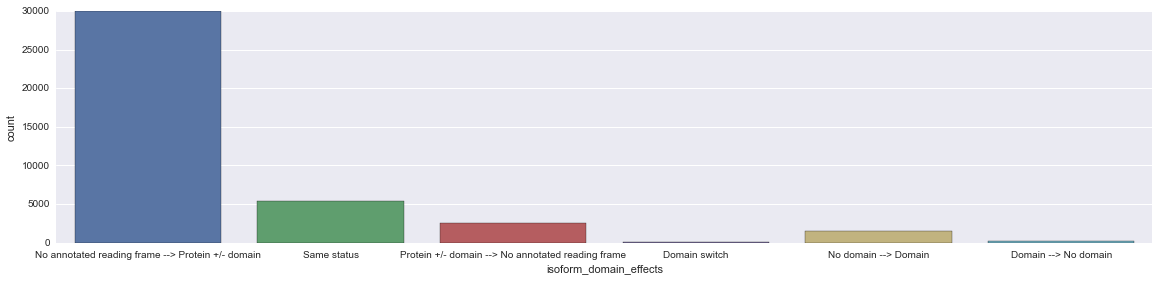

In [35]:
import seaborn as sns
%matplotlib inline
sns.factorplot(x='isoform_domain_effects', data=splicing_feature_data, kind='count', aspect=4)

### Gene ontology

--2015-09-29 11:50:35--  http://www.geneontology.org/external2go/pfam2go
Resolving www.geneontology.org... 52.27.86.54
Connecting to www.geneontology.org|52.27.86.54|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 696293 (680K) [text/plain]
Saving to: `pfam2go.2'

100%[======================================>] 696,293     2.77M/s   in 0.2s    

2015-09-29 11:50:35 (2.77 MB/s) - `pfam2go.2' saved [696293/696293]



/home/obotvinnik/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  ParserWarning)


,pfam,go,pfam_accession,pfam_id,go_name,go_id,go_name_only
pfam_accession_only,,,,,,,
PF00001,Pfam:PF00001 7tm_1,GO:G-protein coupled receptor activity ; GO:0004930,Pfam:PF00001,7tm_1,GO:G-protein coupled receptor activity,GO:0004930,G-protein coupled receptor activity
PF00001,Pfam:PF00001 7tm_1,GO:G-protein coupled receptor signaling pathway ; GO:0007186,Pfam:PF00001,7tm_1,GO:G-protein coupled receptor signaling pathway,GO:0007186,G-protein coupled receptor signaling pathway
PF00001,Pfam:PF00001 7tm_1,GO:integral component of membrane ; GO:0016021,Pfam:PF00001,7tm_1,GO:integral component of membrane,GO:0016021,integral component of membrane
PF00002,Pfam:PF00002 7tm_2,GO:G-protein coupled receptor activity ; GO:0004930,Pfam:PF00002,7tm_2,GO:G-protein coupled receptor activity,GO:0004930,G-protein coupled receptor activity
PF00002,Pfam:PF00002 7tm_2,GO:G-protein coupled receptor signaling pathway ; GO:0007186,Pfam:PF00002,7tm_2,GO:G-protein coupled receptor signaling pathway,GO:0007186,G-protein coupled receptor signaling pathway


### Get event to Pfam Accession and Name

In [38]:
from collections import Counter

grouped = hmmscan_filtered.groupby(['event_name', 'isoform'])
event_to_pfam_accession = grouped.apply(lambda x: ','.join('{}[{}]'.format(k, v) for k, v in Counter(x['target_accession']).items()))
event_to_pfam_accession.head()

event_name                                                                                          isoform 
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-  isoform2    nan[1]
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-  isoform1    nan[1]
                                                                                                    isoform2    nan[1]
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-  isoform1    nan[1]
                                                                                                    isoform2    nan[1]
dtype: object

In [39]:
pfam_accession_tidy = hmmscan_filtered.groupby(['event_name', 'isoform']).apply(
    lambda x: pd.Series(Counter(x['target_accession'])))
pfam_accession_tidy = pfam_accession_tidy.dropna()
pfam_accession_tidy = pfam_accession_tidy.reset_index()
pfam_accession_tidy = pfam_accession_tidy.rename(columns={'level_2': 'pfam_accession', 0: 'n_domains'})
pfam_accession_tidy.head()


,event_name,isoform,pfam_accession,n_domains
0,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,isoform2,PF00155.16,1
1,exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,isoform2,PF01150.12,1
2,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,isoform2,PF02628.10,1
3,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+,isoform2,PF03932.9,2
4,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,isoform1,PF03932.9,1


In [40]:
pfam_accession_to_name = pd.Series(hmmscan_filtered.target_name.values, index=hmmscan_filtered.target_accession.values,
                                  name='pfam_name')
print pfam_accession_to_name.shape
pfam_accession_to_name = pfam_accession_to_name.drop_duplicates()
pfam_accession_to_name.head()
print pfam_accession_to_name.shape

(75329,)
(3064,)


In [41]:
pfam_tidy = pfam_accession_tidy.join(pfam_accession_to_name, on='pfam_accession')
print 'pfam_tidy.shape', pfam_tidy.shape
pfam_tidy.head()

pfam_tidy.shape (30286, 5)


,event_name,isoform,pfam_accession,n_domains,pfam_name
0,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,isoform2,PF00155.16,1,Aminotran_1_2
1,exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,isoform2,PF01150.12,1,GDA1_CD39
2,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,isoform2,PF02628.10,1,COX15-CtaA
3,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+,isoform2,PF03932.9,2,CutC
4,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,isoform1,PF03932.9,1,CutC


In [42]:
pfam_tidy['pfam_accession_no_version'] = pfam_tidy.pfam_accession.str.split('.').str[0]
pfam_tidy.head()

,event_name,isoform,pfam_accession,n_domains,pfam_name,pfam_accession_no_version
0,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,isoform2,PF00155.16,1,Aminotran_1_2,PF00155
1,exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,isoform2,PF01150.12,1,GDA1_CD39,PF01150
2,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,isoform2,PF02628.10,1,COX15-CtaA,PF02628
3,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+,isoform2,PF03932.9,2,CutC,PF03932
4,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,isoform1,PF03932.9,1,CutC,PF03932


In [43]:
pfam_to_go.head()

,pfam,go,pfam_accession,pfam_id,go_name,go_id,go_name_only
pfam_accession_only,,,,,,,
PF00001,Pfam:PF00001 7tm_1,GO:G-protein coupled receptor activity ; GO:0004930,Pfam:PF00001,7tm_1,GO:G-protein coupled receptor activity,GO:0004930,G-protein coupled receptor activity
PF00001,Pfam:PF00001 7tm_1,GO:G-protein coupled receptor signaling pathway ; GO:0007186,Pfam:PF00001,7tm_1,GO:G-protein coupled receptor signaling pathway,GO:0007186,G-protein coupled receptor signaling pathway
PF00001,Pfam:PF00001 7tm_1,GO:integral component of membrane ; GO:0016021,Pfam:PF00001,7tm_1,GO:integral component of membrane,GO:0016021,integral component of membrane
PF00002,Pfam:PF00002 7tm_2,GO:G-protein coupled receptor activity ; GO:0004930,Pfam:PF00002,7tm_2,GO:G-protein coupled receptor activity,GO:0004930,G-protein coupled receptor activity
PF00002,Pfam:PF00002 7tm_2,GO:G-protein coupled receptor signaling pathway ; GO:0007186,Pfam:PF00002,7tm_2,GO:G-protein coupled receptor signaling pathway,GO:0007186,G-protein coupled receptor signaling pathway


In [45]:
event_to_isoform_pfam_name = pfam_tidy.groupby(['event_name', 'isoform']).apply(
    lambda x: ','.join('{}[{}]'.format(a, int(b)) for a, b in zip(x.pfam_name, x.n_domains)))
event_to_isoform_pfam_name.name = 'pfam_name'
event_to_isoform_pfam_name.head()

event_name                                                                                          isoform 
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-  isoform2    Aminotran_1_2[1]
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+  isoform2        GDA1_CD39[1]
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-  isoform2       COX15-CtaA[1]
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+  isoform2             CutC[2]
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+  isoform1             CutC[1]
Name: pfam_name, dtype: object

In [47]:
event_to_isoform_pfam_accession = pfam_tidy.groupby(['event_name', 'isoform']).apply(
    lambda x: ','.join('{}[{}]'.format(a, int(b)) for a, b in zip(x.pfam_accession, x.n_domains)))
event_to_isoform_pfam_accession.name = 'pfam_accession'
event_to_isoform_pfam_accession.head()

event_name                                                                                          isoform 
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-  isoform2    PF00155.16[1]
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+  isoform2    PF01150.12[1]
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-  isoform2    PF02628.10[1]
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+  isoform2     PF03932.9[2]
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+  isoform1     PF03932.9[1]
Name: pfam_accession, dtype: object

### Add GO annotation

In [48]:
! wget http://www.geneontology.org/external2go/pfam2go 

pfam_to_go = pd.read_table('pfam2go', sep=' > ', skiprows=6, header=None, names=['pfam', 'go'])
# pfam_to_go.head()
pfam_to_go[['pfam_accession', 'pfam_id']] = pfam_to_go.pfam.str.split(' ').apply(pd.Series)
# pfam_to_go.head()
pfam_to_go[['go_name', 'go_id']] = pfam_to_go.go.str.split(' ; ').apply(pd.Series)
# pfam_to_go.head()
pfam_to_go['pfam_accession_only'] = pfam_to_go.pfam_accession.str.split(':').str[1]
# pfam_to_go.head()
pfam_to_go = pfam_to_go.set_index('pfam_accession_only')
# pfam_to_go.head()
pfam_to_go['go_name_only'] = pfam_to_go.go_name.str.split(':').str[1]
pfam_to_go.head()

--2015-09-29 11:52:19--  http://www.geneontology.org/external2go/pfam2go
Resolving www.geneontology.org... 52.27.86.54
Connecting to www.geneontology.org|52.27.86.54|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 696293 (680K) [text/plain]
Saving to: `pfam2go.3'

100%[======================================>] 696,293     3.00M/s   in 0.2s    

2015-09-29 11:52:19 (3.00 MB/s) - `pfam2go.3' saved [696293/696293]



,pfam,go,pfam_accession,pfam_id,go_name,go_id,go_name_only
pfam_accession_only,,,,,,,
PF00001,Pfam:PF00001 7tm_1,GO:G-protein coupled receptor activity ; GO:0004930,Pfam:PF00001,7tm_1,GO:G-protein coupled receptor activity,GO:0004930,G-protein coupled receptor activity
PF00001,Pfam:PF00001 7tm_1,GO:G-protein coupled receptor signaling pathway ; GO:0007186,Pfam:PF00001,7tm_1,GO:G-protein coupled receptor signaling pathway,GO:0007186,G-protein coupled receptor signaling pathway
PF00001,Pfam:PF00001 7tm_1,GO:integral component of membrane ; GO:0016021,Pfam:PF00001,7tm_1,GO:integral component of membrane,GO:0016021,integral component of membrane
PF00002,Pfam:PF00002 7tm_2,GO:G-protein coupled receptor activity ; GO:0004930,Pfam:PF00002,7tm_2,GO:G-protein coupled receptor activity,GO:0004930,G-protein coupled receptor activity
PF00002,Pfam:PF00002 7tm_2,GO:G-protein coupled receptor signaling pathway ; GO:0007186,Pfam:PF00002,7tm_2,GO:G-protein coupled receptor signaling pathway,GO:0007186,G-protein coupled receptor signaling pathway


In [49]:
join_cols = pfam_to_go.columns.difference(pfam_tidy.columns)
pfam_tidy_go = pfam_tidy.join(pfam_to_go[join_cols], on='pfam_accession_no_version')
pfam_tidy_go.head()

,event_name,isoform,pfam_accession,n_domains,pfam_name,pfam_accession_no_version,go,go_id,go_name,go_name_only,pfam,pfam_id
0,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,isoform2,PF00155.16,1,Aminotran_1_2,PF00155,GO:pyridoxal phosphate binding ; GO:0030170,GO:0030170,GO:pyridoxal phosphate binding,pyridoxal phosphate binding,Pfam:PF00155 Aminotran_1_2,Aminotran_1_2
0,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,isoform2,PF00155.16,1,Aminotran_1_2,PF00155,GO:biosynthetic process ; GO:0009058,GO:0009058,GO:biosynthetic process,biosynthetic process,Pfam:PF00155 Aminotran_1_2,Aminotran_1_2
1,exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,isoform2,PF01150.12,1,GDA1_CD39,PF01150,GO:hydrolase activity ; GO:0016787,GO:0016787,GO:hydrolase activity,hydrolase activity,Pfam:PF01150 GDA1_CD39,GDA1_CD39
2,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,isoform2,PF02628.10,1,COX15-CtaA,PF02628,"GO:oxidoreductase activity, acting on the CH-CH group of donors ; GO:0016627",GO:0016627,"GO:oxidoreductase activity, acting on the CH-CH group of donors","oxidoreductase activity, acting on the CH-CH group of donors",Pfam:PF02628 COX15-CtaA,COX15-CtaA
2,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,isoform2,PF02628.10,1,COX15-CtaA,PF02628,GO:heme a biosynthetic process ; GO:0006784,GO:0006784,GO:heme a biosynthetic process,heme a biosynthetic process,Pfam:PF02628 COX15-CtaA,COX15-CtaA


In [51]:
event_to_isoform_pfam_go_id = pfam_tidy_go.groupby(['event_name', 'isoform']).apply(
    lambda x: ','.join('{}[{}]'.format(a, int(b)) for a, b in zip(x.go_id, x.n_domains)))
event_to_isoform_pfam_go_id.name = 'pfam_go_id'
event_to_isoform_pfam_go_id.head()

event_name                                                                                          isoform 
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-  isoform2                                GO:0030170[1],GO:0009058[1]
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+  isoform2                                              GO:0016787[1]
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-  isoform2    GO:0016627[1],GO:0006784[1],GO:0055114[1],GO:0016021[1]
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+  isoform2                                GO:0005507[2],GO:0055070[2]
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+  isoform1                                GO:0005507[1],GO:0055070[1]
Name: pfam_go_id, dtype: object

In [52]:
event_to_isoform_pfam_go_name = pfam_tidy_go.groupby(['event_name', 'isoform']).apply(
    lambda x: ','.join('({})[{}]'.format(a, int(b)) for a, b in zip(x.go_name_only, x.n_domains)))
event_to_isoform_pfam_go_name.name = 'pfam_go_name'
event_to_isoform_pfam_go_name.head()

event_name                                                                                          isoform 
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-  isoform2                                             (pyridoxal phosphate binding)[1],(biosynthetic process)[1]
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+  isoform2                                                                                (hydrolase activity)[1]
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-  isoform2    (oxidoreductase activity, acting on the CH-CH group of donors)[1],(heme a biosynthetic process)[...
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+  isoform2                                                    (copper ion binding)[2],(copper ion homeostasis)[2]
exon:chr10:101507014-101507147:+@exon:chr10

In [53]:
event_to_isoform_series = {'pfam_go_name': event_to_isoform_pfam_go_name, 
                           'pfam_go_id': event_to_isoform_pfam_go_id,
                           'pfam_name': event_to_isoform_pfam_name, 
                           'pfam_accession': event_to_isoform_pfam_accession}

In [54]:
for name, series in event_to_isoform_series.items():
    df = series.unstack()
    df.columns = df.columns.map(lambda x: x + '_' + name)
    print df.head()
    splicing_feature_data = splicing_feature_data.join(df)
splicing_feature_data.head()

                                                                                                   isoform1_pfam_accession  \
event_name                                                                                                                   
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-                     NaN   
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+                     NaN   
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-                     NaN   
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+                     NaN   
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+            PF03932.9[1]   

                                                                                                   isoform2_pfam_acce

,gencode_id,ensembl_id,gene_name,exon1_length,exon2_length,exon3_length,intron1_length,intron2_length,exon2_divisible_by_3,intron12_length_summed,one_ensembl_id,skipped_exon_exon2_splice_site_3p_score,skipped_exon_exon2_splice_site_3p_seq,skipped_exon_exon2_splice_site_5p_score,skipped_exon_exon2_splice_site_5p_seq,...,isoform1_translation,isoform2_translation,isoform1_aromaticity,isoform2_aromaticity,isoform1_molecular_weight,isoform2_molecular_weight,isoform_domain_effects,isoform1_pfam_accession,isoform2_pfam_accession,isoform1_pfam_name,isoform2_pfam_name,isoform1_pfam_go_name,isoform2_pfam_go_name,isoform1_pfam_go_id,isoform2_pfam_go_id
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,492,681,148,True,829,ENSG00000107521,7.77,CTCTCCCCTGCCCTGCACAGCCT,6.96,ACGGTGTGT,...,NaN,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSS,NaN,0.056179775280898875,NaN,9467.055499999997,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,487,681,148,True,829,ENSG00000107521,7.77,CTCTCCCCTGCCCTGCACAGCCT,6.96,ACGGTGTGT,...,HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFTPAPSPGDQSSGEDRRKAGGNNS,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSS,0.058823529411764705,0.056179775280898875,7294.6994,9467.055499999997,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,70,681,148,True,829,ENSG00000107521,7.77,CTCTCCCCTGCCCTGCACAGCCT,6.96,ACGGTGTGT,...,HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFTPAPSPGDQSS,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSS,0.07142857142857142,0.056179775280898875,6052.4400000000005,9467.055499999997,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,ENSG00000107521.14,ENSG00000107521,HPS1,152,161,100,2648,460,False,3108,ENSG00000107521,9.08,TCCCTTCCTGCCCTGGCTAGGCC,7.96,TAGGTGAGC,...,NaN,LRPPDLAQRVQLWEHFQSLLWTYSRLREQEQCFAVEALERLIHPQLCELCIEALERHVIQAVNTSPERGGEEALHAFLLVHSKLLAFYSSHSASSL...,NaN,0.07317073170731708,NaN,14073.84609999998,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,ENSG00000107521.14,ENSG00000107521,HPS1,138,143,152,220,1180,False,1400,ENSG00000107521,7.92,TGGCCTGCCTGTGCCTGCAGTTT,6.05,GGAGTGAGT,...,NaN,LPALEDQLSTLLAPVIISSMTMLEKLSDTYTCFSTENGNFLYVLHLFGECLFIAINGDHTESEGDLRRKLYVLKYLFEVHFGLVTVDGHLIRKELR...,NaN,0.11538461538461539,NaN,15151.241699999982,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
splicing_feature_data.shape

(58842, 50)

## Save the data!

In [56]:
splicing_feature_data.to_csv('/projects/ps-yeolab/obotvinnik/singlecell_pnms/splicing_feature_data.csv')

In [58]:
sorted(splicing_feature_data.columns)

['ensembl_id',
 'exon1_length',
 'exon2_divisible_by_3',
 'exon2_length',
 'exon2_merkin2012_ancient',
 'exon2_splice_site_3p_score',
 'exon2_splice_site_3p_seq',
 'exon2_splice_site_5p_score',
 'exon2_splice_site_5p_seq',
 'exon3_length',
 'gencode_id',
 'gene_name',
 'intron12_length_summed',
 'intron1_length',
 'intron2_length',
 'isoform1_aromaticity',
 'isoform1_gravy',
 'isoform1_instability_index',
 'isoform1_isoelectric_point',
 'isoform1_iupred_score',
 'isoform1_molecular_weight',
 'isoform1_pfam_accession',
 'isoform1_pfam_go_id',
 'isoform1_pfam_go_name',
 'isoform1_pfam_name',
 'isoform1_protein_secondary_structure_helix',
 'isoform1_protein_secondary_structure_sheet',
 'isoform1_protein_secondary_structure_turn',
 'isoform1_translation',
 'isoform2_aromaticity',
 'isoform2_gravy',
 'isoform2_instability_index',
 'isoform2_isoelectric_point',
 'isoform2_iupred_score',
 'isoform2_molecular_weight',
 'isoform2_pfam_accession',
 'isoform2_pfam_go_id',
 'isoform2_pfam_go_name'